NLP Project

In [30]:
import numpy as np
import pandas as pd
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [32]:
# Preprocessing

# Stopwords
stopwords = set(stopwords.words('english'))

# Detokenizer to combines tokens together
detokenizer = TreebankWordDetokenizer()

# Tokenizer and cleaning function
def clean_text(description):
  description = word_tokenize(description.lower())
  description = [token for token in description if token not in stopwords and token.isalpha()]
  return detokenizer.detokenize(description)


In [33]:
# Apply Function

df["description"] = df["description"].apply(clean_text)
df.head(2)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,aromas include tropical fruit broom brimstone ...,Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,ripe fruity wine smooth still structured firm ...,Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


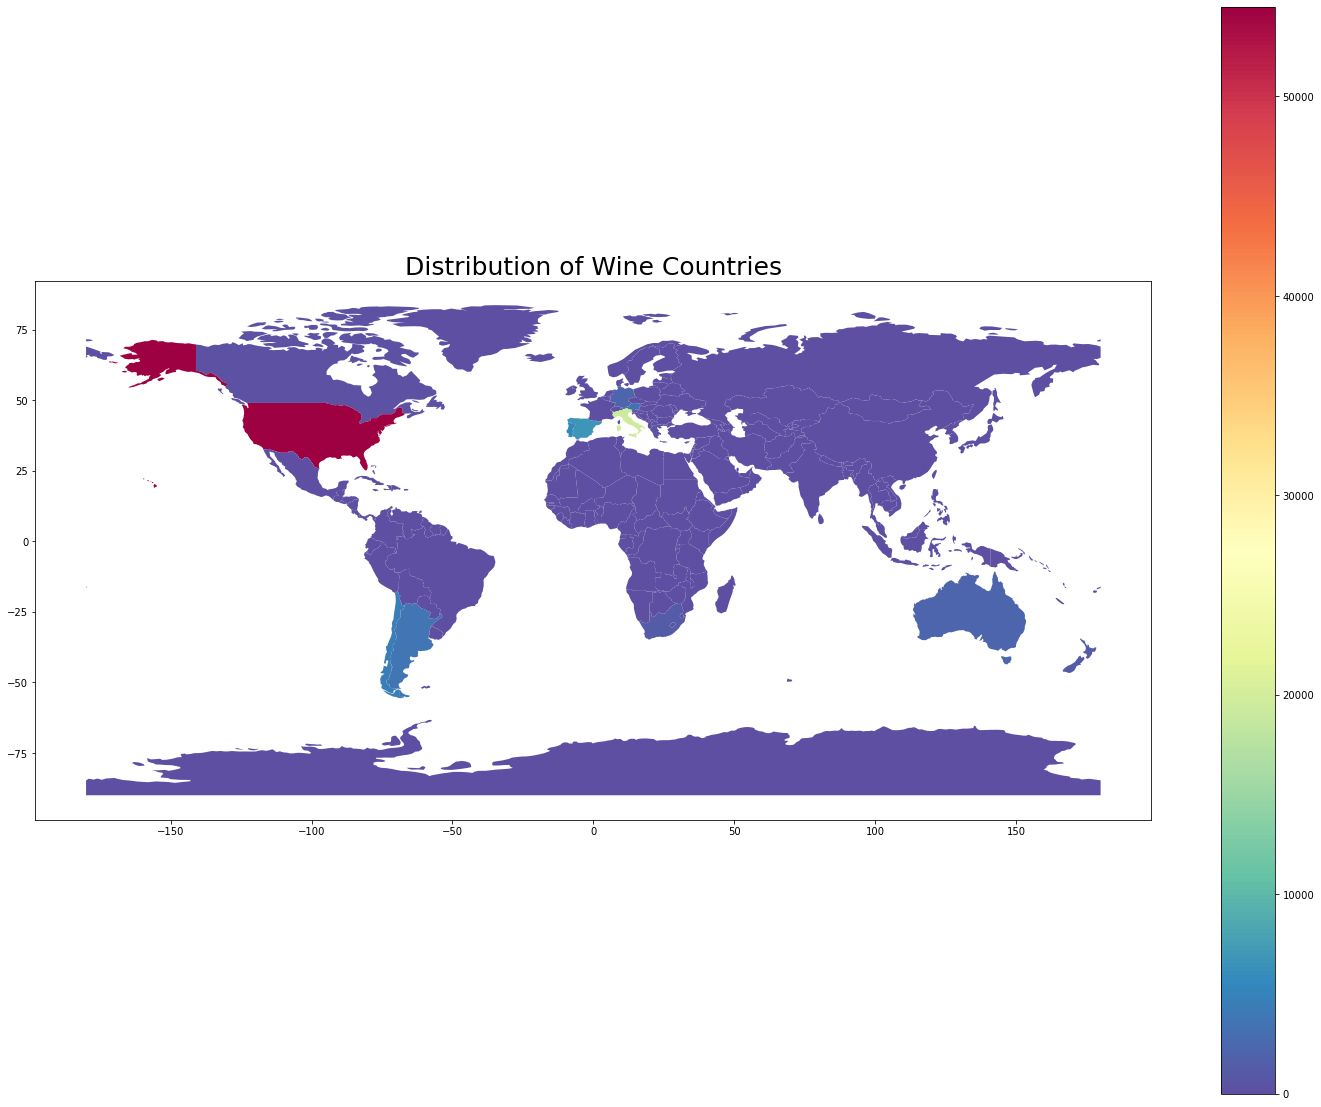

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
#import folium
import seaborn as sns
import pycountry

df_counts = df['country'].value_counts().to_frame()
df_counts.reset_index(inplace = True)




def convert_us(country):
    if country == 'US':
        return 'United States'
    else:
        return country

    
df_counts["index"] = df_counts["index"].apply(convert_us)


# generate country code  based on country name 

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
df_counts['CODE']=alpha3code(df_counts['index'])
len(df_counts)

# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,df_counts,on='CODE')
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge=merge.merge(location,on='name').sort_values(by='country',ascending=False).reset_index()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

mapped = world.merge(merge[['CODE', 'country']], how='left', left_on='iso_a3', right_on='CODE')
mapped = mapped.fillna(0)

# plot confirmed cases world map 
mapped.plot(column='country',
           figsize=(25, 20),
           legend=True,cmap='Spectral_r')
plt.title('Distribution of Wine Countries',fontsize=25)
# add countries names and numbers 
#for i in range(0,10):
#    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge.country[i]),size=10)
plt.show()


In [35]:
countries = df.loc[:, ['description','country']]

In [36]:
countries.dropna(inplace = True)
countries

,description,country
0,aromas include tropical fruit broom brimstone ...,Italy
1,ripe fruity wine smooth still structured firm ...,Portugal
2,tart snappy flavors lime flesh rind dominate g...,US
3,pineapple rind lemon pith orange blossom start...,US
4,much like regular bottling comes across rather...,US
...,...,...
129966,notes honeysuckle cantaloupe sweeten delicious...,Germany
129967,citation given much decade bottle age prior re...,US
129968,gravel soil gives wine crisp dry character rip...,France
129969,dry style pinot gris crisp acidity also weight...,France


In [37]:
def countries_to_class(country):
    if country == 'US':
        return 'US'
    elif country == 'France':
        return 'France'
    elif country == 'Italy':
        return 'Italy'

    
countries["country class"] = countries["country"].apply(countries_to_class)

In [38]:
#countries["country class"] = countries["country"]

In [39]:
countries = countries[countries['country class'].notna()]
#countries = countries.drop(columns = 'country')
countries

,description,country,country class
0,aromas include tropical fruit broom brimstone ...,Italy,Italy
2,tart snappy flavors lime flesh rind dominate g...,US,US
3,pineapple rind lemon pith orange blossom start...,US,US
4,much like regular bottling comes across rather...,US,US
6,bright informal red opens aromas candied berry...,Italy,Italy
...,...,...,...
129965,rich beautiful dry wine also offers considerab...,France,France
129967,citation given much decade bottle age prior re...,US,US
129968,gravel soil gives wine crisp dry character rip...,France,France
129969,dry style pinot gris crisp acidity also weight...,France,France


In [40]:

def get_vector_feature_matrix(description):
    vectorizer = CountVectorizer(lowercase=True, stop_words="english",ngram_range=(1,2), max_features=2000, max_df=0.9) #use most common 1000 words to make a prediction
    vector = vectorizer.fit_transform(description)
    return vector, vectorizer

vector, vectorizer = get_vector_feature_matrix(countries['description'])

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
countries['country class'] = labelencoder.fit_transform(countries['country class'])

features=vector
label = countries['country class']

# Split the training and test 70/30
X, y = features, label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


Logistic Regresson

In [41]:
# Logistic Regresson Model

lr = LogisticRegression(multi_class='multinomial',solver='lbfgs')
lr_model = lr.fit(X_train, y_train)

accuracy_lr = lr_model.score(X_test, y_test)
print ("Logistic Regression Classifier Accuracy is {}".format(accuracy_lr))

Logistic Regression Classifier Accuracy is 0.9609250398724083


In [42]:
pred_rfc = lr_model.predict(X_test)
#print(classification_report(y_test, pred_rfc))
report_lr = classification_report(y_test, pred_rfc, output_dict=True)

df_lr = pd.DataFrame(report_lr).transpose().round(4)
df_lr

,precision,recall,f1-score,support
0,0.9476,0.9363,0.9419,6621.0000
1,0.9702,0.9525,0.9613,5919.0000
2,0.9629,0.9740,0.9684,16302.0000
accuracy,0.9609,0.9609,0.9609,0.9609
macro avg,0.9602,0.9543,0.9572,28842.0000
weighted avg,0.9609,0.9609,0.9609,28842.0000


Decision Tree

In [43]:
# Decision Tree Model 

tree = DecisionTreeClassifier()
tree_model=tree.fit(X_train, y_train)

accuracy_tree = tree_model.score(X_test, y_test)
print ("Decision Tree Classifier Accuracy is {}".format(accuracy_tree))

Decision Tree Classifier Accuracy is 0.8640177518896054


In [44]:
pred_rfc = tree_model.predict(X_test)
#print(classification_report(y_test, pred_rfc))

report_dt = classification_report(y_test, pred_rfc, output_dict=True)

df_dt = pd.DataFrame(report_dt).transpose().round(4)
df_dt

,precision,recall,f1-score,support
0,0.8111,0.8166,0.8139,6621.000
1,0.8596,0.8366,0.8479,5919.000
2,0.8871,0.8932,0.8901,16302.000
accuracy,0.8640,0.8640,0.8640,0.864
macro avg,0.8526,0.8488,0.8506,28842.000
weighted avg,0.8640,0.8640,0.8640,28842.000


In [45]:
# Random Forest Model

rf = RandomForestClassifier(n_estimators=200)
rf_model=rf.fit(X_train, y_train)

accuracy_rf = rf_model.score(X_test, y_test)
#print ("Random Forest Classifier Accuracy is {}".format(accuracy_rf))

In [46]:
pred_rfc = rf_model.predict(X_test)
#print(classification_report(y_test, pred_rfc))

report_rf = classification_report(y_test, pred_rfc, output_dict=True)

df_rf = pd.DataFrame(report_rf).transpose().round(4)
df_rf

,precision,recall,f1-score,support
0,0.9587,0.8666,0.9104,6621.0000
1,0.9805,0.9002,0.9386,5919.0000
2,0.9207,0.9841,0.9513,16302.0000
accuracy,0.9399,0.9399,0.9399,0.9399
macro avg,0.9533,0.9169,0.9334,28842.0000
weighted avg,0.9417,0.9399,0.9393,28842.0000


In [47]:
df_rf_compare = df_rf.loc[['0','1','2'],'recall'].to_frame()
df_rf_compare.rename(columns = ({'recall' : 'Random Forest Recall'}), inplace = True)

df_dt_compare = df_dt.loc[['0','1','2'],'recall'].to_frame()
df_dt_compare.rename(columns = ({'recall' : 'Decision Tree Recall'}), inplace = True)

df_lr_compare = df_lr.loc[['0','1','2'],'recall'].to_frame()
df_lr_compare.rename(columns = ({'recall' : 'Logistic Regression Recall'}), inplace = True)

recall = df_rf_compare.merge(df_dt_compare, left_index = True, right_index = True)
recall = recall.merge(df_lr_compare, left_index = True, right_index = True)
recall = recall.transpose()
recall.reset_index(inplace=True)
recall

,index,0,1,2
0,Random Forest Recall,0.8666,0.9002,0.9841
1,Decision Tree Recall,0.8166,0.8366,0.8932
2,Logistic Regression Recall,0.9363,0.9525,0.9740


In [48]:
import plotly_express as px
fig = px.histogram(recall, x=["0", '1', '2'],y = "index",
             barmode='group',
             height=400, title = 'Countries Recall')
fig.show()

In [49]:
df_accuracies = pd.DataFrame({"index":["Logistic Regression Accuracy", "Decision Tree Accuracy", "Random Forest Accuracy"],
                    "Accuracy":[accuracy_lr, accuracy_tree, accuracy_rf]})

fig = px.histogram(df_accuracies, x='Accuracy',y = "index",
             barmode='group',
             height=400, title = 'Countries Accuracy')
fig.show()

In [50]:
united_states = df[df['country'] == 'US']
united_states

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,2,US,tart snappy flavors lime flesh rind dominate g...,NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,much like regular bottling comes across rather...,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,US,soft supple plum envelopes oaky structure cabe...,Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,12,US,slightly reduced wine offers chalky tannic bac...,NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129945,129945,US,hailing one popular vineyards varietal whole c...,Jurassic Park Vineyard Old Vines,90,20.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,@mattkettmann,Birichino 2013 Jurassic Park Vineyard Old Vine...,Chenin Blanc,Birichino
129949,129949,US,bones use oak wine spent nine months enjoying ...,Barrel Fermented,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs
129950,129950,US,opens herbaceous dollops thyme earth evolves s...,Blocks 7 & 22,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Zinfandel,Hendry
129952,129952,US,zinfandel eastern section napa valley unexpect...,NaN,90,22.0,California,Chiles Valley,Napa,Virginie Boone,@vboone,Houdini 2011 Zinfandel (Chiles Valley),Zinfandel,Houdini


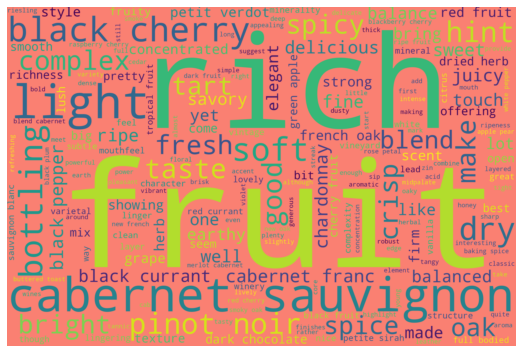

In [60]:
text = " ".join(review for review in united_states.description)
stopwords.update(["drink", "now", "wine", "flavor", "flavors", "aromas","palate", "acidity",'nose', "finish",'nose',"tannins", "note", 'show', 'offer', 'notes', 'offers', 'give', 'shows', 'also', 'along'])
# Generate a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000,stopwords=stopwords, background_color="salmon").generate(text)
fig= plt.figure(figsize = (10,5))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()



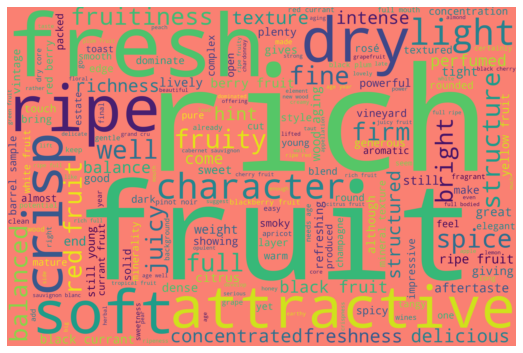

In [59]:
france = df[df['country'] == 'France']

text = " ".join(review for review in france.description)
stopwords.update(["drink", "now", "wine", "flavor", "flavors", "aromas",'ready', "palate", "acidity","finish","tannins", "note", 'show', 'offer','nose', 'notes', 'offers', 'give', 'shows', 'also', 'along'])
# Generate a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000,stopwords=stopwords, background_color="salmon").generate(text)
fig= plt.figure(figsize = (10,5))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()


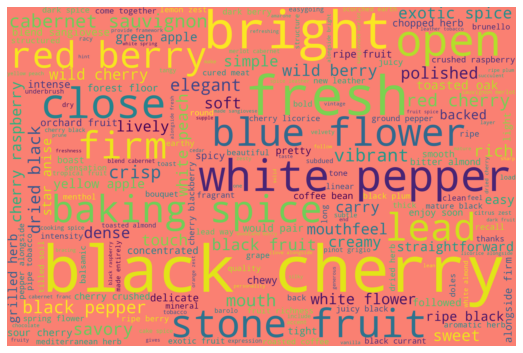

In [61]:
italy = df[df['country'] == 'Italy']

text = " ".join(review for review in italy.description)
stopwords.update(["drink", "now", "wine", "flavor", "flavors", 'deliver','delivers', "aromas","palate", "acidity","finish","tannins", "note", 'show', 'offer','nose', 'notes', 'offers', 'give', 'shows', 'also', 'along'])
# Generate a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000,stopwords=stopwords, background_color="salmon").generate(text)
fig= plt.figure(figsize = (10,5))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()
